In [402]:
from __future__ import annotations

import os
import re
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from datetime import datetime
from string import whitespace, punctuation
from spacy.tokens.doc import Doc
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from itertools import chain
import tensorflow as tf
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, Input, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.framework.ops import EagerTensor
from keras.engine.functional import Functional
from keras.layers import Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import Iterable, Generator, List

In [403]:
sns.set_style("darkgrid", {'axes.grid' : True})

# Define global variables & constants

In [404]:
COLUMNS = ['Subject', 'Message', 'Is Phishy']
DATABASE_PATH = r'..\resources\database'
LSTM_PATH = r'..\models\LSTM'
SAVE_MODEL = False

# Load the dataset

In [405]:
emails_csv = os.path.join(DATABASE_PATH, 'emails-database.csv')

In [406]:
emails_df1 = pd.read_csv(emails_csv, usecols=['Subject', 'Extracted Text', 'Is Phishy'], dtype={'Is Phishy': int})

In [407]:
emails_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8837 entries, 0 to 8836
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Subject         8705 non-null   object
 1   Extracted Text  8747 non-null   object
 2   Is Phishy       8837 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 172.7+ KB


# Load the second dataset

In [408]:
emails_zip = os.path.join(DATABASE_PATH, 'fraud_email_.csv.zip')

In [409]:
emails_df2 = pd.read_csv(emails_zip)

Prepend empty 'Subject' column so that the dimensions and columns order match for joining

In [410]:
emails_df2.insert(loc=0, column='Subject', value=np.full(shape=(emails_df2.shape[0],), fill_value=np.nan))

In [411]:
emails_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11929 entries, 0 to 11928
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Subject  0 non-null      float64
 1   Text     11928 non-null  object 
 2   Class    11929 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 279.7+ KB


# Join tables

In [412]:
emails_df = pd.DataFrame(np.r_[emails_df1, emails_df2], columns=COLUMNS)

# Analyze textual data
Remove any rows where either Raw Message or Phishy is missing.

In [413]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20766 entries, 0 to 20765
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    8705 non-null   object
 1   Message    20675 non-null  object
 2   Is Phishy  20766 non-null  object
dtypes: object(3)
memory usage: 486.8+ KB


In [414]:
emails_df.dropna(how='any', subset=['Message', 'Is Phishy'], inplace=True)

## Visualize data distribution

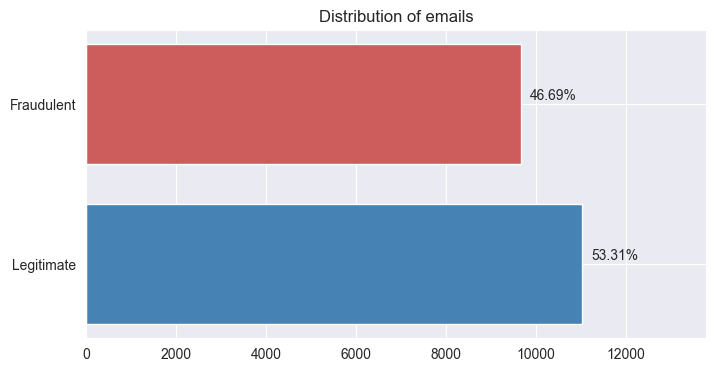

In [415]:
phishy_freqs = emails_df['Is Phishy'].value_counts()

plt.figure(figsize=(8, 4))
sns.set_style("darkgrid")
plt.barh(y=phishy_freqs.index, width=phishy_freqs.values, height=0.75, color=['steelblue', 'indianred'], align='center')
plt.title('Distribution of emails')
plt.yticks([0, 1], ['Legitimate', 'Fraudulent'])
plt.xlim([0, phishy_freqs.max() * 1.25])
 
# Text right-aligned to each horizontal bar
percentage = ["{:.2f}%".format((f / phishy_freqs.sum()) * 100) for f in phishy_freqs]
for i, perc in enumerate(percentage):
    plt.text(x=phishy_freqs[i] + 200, y=i + 0.025, s=perc, size=10)
 
plt.show()

In [416]:
def get_subject_prefix(subject: str) -> str:
    try:
        rgx = re.compile(r"^(re)|(fw)(?:d?):?(.*)$", flags=re.IGNORECASE)
        return next(x.title() for x in re.match(rgx, subject if isinstance(subject, str) else '').groups() if x)
    except AttributeError:
        return ''

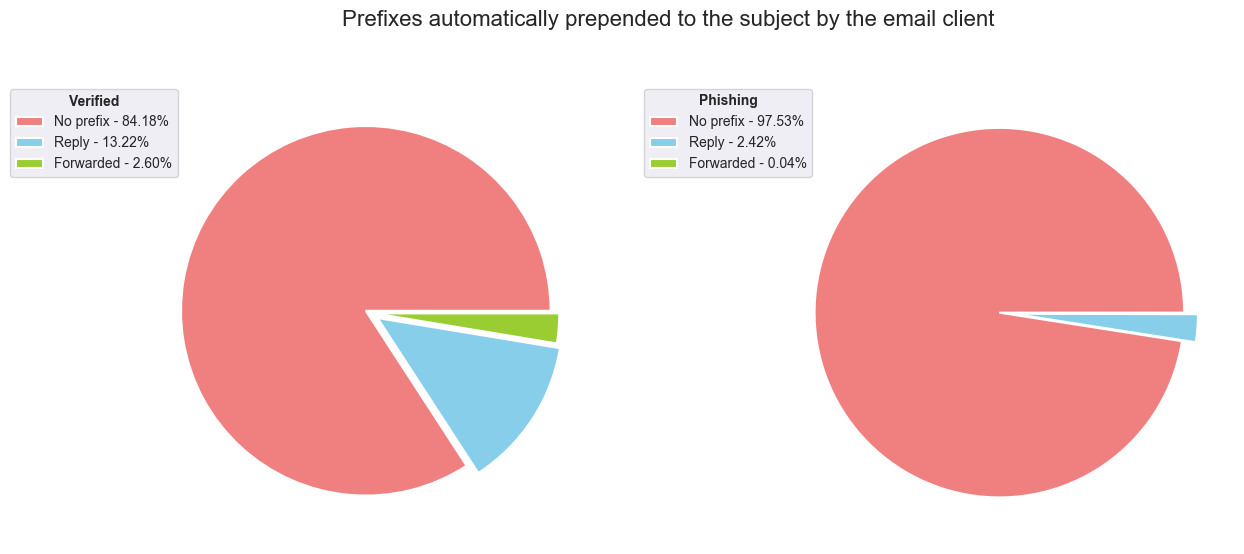

In [417]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
abbreviations = {
    'Re': 'Reply',
    'Fw': 'Forwarded'
}
for i, title in zip([0, 1], ['Verified', 'Phishing']):
    subject_groups = emails_df.loc[emails_df['Is Phishy'] == i, 'Subject'].apply(get_subject_prefix).value_counts()
    percentage = 100. * subject_groups / subject_groups.sum()
    ax[i].pie(
        subject_groups, 
        colors=['lightcoral', 'skyblue', 'yellowgreen'], 
        explode=(0.025, 0.05, 0.025), 
        wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'}
    )
    
    labels = ['{0} - {1:1.2f}%'.format(abbreviations.get(label, 'No prefix'), value) for label, value in percentage.items()]
    ax[i].legend(labels, title=title, bbox_to_anchor=(0.1, 1.), fancybox=True, title_fontproperties={'weight': 'bold'})

plt.suptitle("Prefixes automatically prepended to the subject by the email client", y=1., fontsize=16)
plt.show()

## Perform stratified shuffle split

In [418]:
# Feature matrix must be multidimensional as it is propagated through a pipeline to transformers
X = emails_df[['Subject', 'Message']] # .sample(1000, random_state=33)
y = emails_df['Is Phishy'].astype(int) # .sample(1000, random_state=33)

In [419]:
# Train, test, validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=33)

# Preprocess text
As part of preprocessing, we need to
perform case-folding, stopword removal. We will not keep single-character words. It might be advantagous to lemmatize words as well. 
Empty rows resulting from text preprocessing should be removed.

In [420]:
class SpacyPreprocessor(BaseEstimator, TransformerMixin):
    """
    Class for custom text preprocessing transformer.
    
    Attributes
    ----------
    nlp : spacy.lang.en.English
        SpaCy trained pipeline supporting English language.
    min_length : int
        Tokens with length shorter than this value are excluded.
    keep_stop : bool
        If true, stopwords are kept. Default is False.
    keep_num_like: bool
        Yield numeric-like tokens. Default is True.
    alpha_only : bool
        Yield alphabetical tokens only. Default is False.
    alnum_only: bool
        Yield alphanumerical tokens only. Default is False.
    ascii_only : bool
        Yield ascii-compliant tokens only. Default is False.

    Methods
    -------
    fit(X, y=None)
        Fit the transformer using X (placeholder).
    transform(self, X)
        Transform X by applying preprocess_corpus function.
    preprocess_corpus(corpus)
        Preprocess text corpus.
    preprocess_document(doc)
        Generator yielding preprocessed tokens for the specified text document.
    clean_document(doc)
        Clean each word within the document and replace multiple whitespaces with a single space.
    clean_word(word)
        Remove any unicode characters, strip whitespaces and punctuation marks, while remaining non-alphanumeric characters within words.

    Usage
    -----
    Add either as a step in sklearn.pipe.Pipeline, or as a transformer in sklearn.compose.ColumnTransformer.
    """
    def __init__(self, min_length: int = 0, keep_stop: bool = False, keep_num_like: bool = True, alpha_only: bool = False, alnum_only: bool = False, ascii_only: bool = False) -> None:
        """
        Constructs all the necessary attributes for the custom transformer object.

        Parameters
        ----------
        min_length : int, optional
            Tokens with length shorter than this value are excluded. Default is 0.
        keep_stop : bool, optional
            If true, stopwords are kept. By default (False) stopwords are removed.
        keep_num_like: bool
            Yield numeric-like tokens. Default is True.
        alpha_only : bool
            Yield alphabetical tokens only. Default is False.
        alnum_only: bool
            Yield alphanumerical tokens only. Default is False.
        ascii_only : bool
            Yield ascii-compliant tokens only. Default is False.
        """
        super(SpacyPreprocessor, self).__init__()
        self.nlp = spacy.load(
            name='en_core_web_sm', 
            disable=["parser", "ner"]
        )
        self.min_length = min_length
        self.keep_stop = keep_stop
        self.keep_num_like = keep_num_like
        self.alpha_only = alpha_only
        self.alnum_only = alnum_only
        self.ascii_only = ascii_only


    def fit(self, X: pd.DataFrame, y=None) -> SpacyPreprocessor:
        """
        Fit the transformer using X (placeholder).

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data, of which specified subsets are used to fit the transformers.
        y : None, optional
            Ignored.
        
        Returns
        -------
        self : AttributeAdder
            This transformer.
        """
        return self
        
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Transform X by applying preprocess_corpus function.

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data to be transformed.
        
        Returns
        -------
        X_t : pd.DataFrame
            Transformed corpus.
        """
        return X.apply(self.preprocess_corpus)
    
    def preprocess_corpus(self, corpus: List[str]) -> List[str]:
        """
        Preprocess text corpus.

        Parameters
        ----------
        corpus : List[str]
            List of text documents.
        
        Returns
        -------
        clean_corpus : List[str]
            Preprocessed text corpus.
        """
        return [
            # Join preprocessed docs
            ' '.join(self.preprocess_document(doc))
            # Apply initial sentence-level cleaning
            for doc in self.nlp.pipe(self.clean_document(doc=str(x)) for x in corpus)
        ]

    def preprocess_document(self, doc: Doc) -> Generator[str, None, None]:
        """
        Generator yielding preprocessed tokens for the specified text document.

        Parameters
        ----------
        doc : spacy.tokens.doc.Doc
            Document object.
        
        Yields
        -------
        lemma : str
            Lemmatized token.
        """
        # Tokenize document
        for token in doc:
            # Exclude tokens shorter than 2 characters
            # Keep in mind that high frequency of extremely short tokens might indicate fraudulent email
            if not len(token.text) >= self.min_length:
                continue

            # Exclude non-ASCII tokens
            # Keep in mind that high frequency of non-ascii characters might indicate fraudulent email
            if self.ascii_only and not token.is_ascii:
                continue 

            # Exclude any non-alphanumeric tokens
            # Keep in mind that high frequency of tokens consisting of special characters might indicate fraudulent email
            if self.alnum_only and not token.text.isalnum():
                continue

            # Exclude non-alphabetic tokens
            # Keep in mind that it limits the vocabulary to alphabetic tokens only, significantly affecting the spectrum of characters
            if self.alpha_only and not token.is_alpha:
              continue
            
            # Exclude numeric-like tokens
            # Keep in mind that high frequency of numeric-like tokens might indicate fraudulent email
            if not self.keep_num_like and token.like_num:
                continue
            
            # Exclude stopwords
            if not self.keep_stop and token.is_stop:
                continue
              
            # Lemmatization
            lemma = token.lemma_

            # Yield lemma
            yield lemma

    @staticmethod
    def clean_document(doc: str) -> str:
        """
        Clean each word within the document and replace multiple whitespaces with a single space. 
        
        Parameters
        ----------
        doc : str
            Input document.
        
        Returns : 
        clean_doc : str
            Clean document.
        """
        words = map(
            lambda s: SpacyPreprocessor.clean_word(s), 
            doc.casefold().split()
        )
        return ' '.join(filter(lambda s: bool(s), words))

    @staticmethod
    def clean_word(word: str) -> str:
        """
        Remove any unicode characters, strip whitespaces and punctuation marks, while remaining non-alphanumeric characters within words. 
        
        Parameters
        ----------
        word : str
            Input word.
        
        Returns : 
        clean_word : str
            Clean word.
        """
        return re.sub(
            r"_x([0-9a-fA-F]{4})_", '', word
        ).strip(whitespace + punctuation)

In [421]:
class TextAttribConcat(BaseEstimator, TransformerMixin): 
    """
    Concatenate multiple columns into a new one by joining the rows with a defined separator.

    Attributes
    ----------
    attribs_in : List[str]
        List of input features to concatenate.
    attrib_out : str
        Feature to add.
    sep : str
        Separator that joins string content in selected columns.

    Methods
    -------
    fit(X, y=None)
        Fit the transformer using X (placeholder).

    transform(self, X)
        Transform X by concatenating input columns into a single one by joining the rows with a defined separator.
    
    Usage
    -----
    Transformation step in the pipeline.
    Let's assume the input feature matrix consists of two columns: ['Title', 'Description']
    We want to concatenate the text content of these columns into one: 'All Details'
    The pipeline should be initialized as:
        
        sklearn.pipe.Pipeline(steps=[
            ...,
            ('all_details', TextAttribConcat(attribs_in=['Title', 'Description'], attrib_out='All Details', sep='-')),
            ...
        ])
    """

    def __init__(self, attribs_in: List[str], attrib_out: str, sep: str = '\n') -> None:
        """
        Constructs all the necessary attributes for the custom transformer object.

        Parameters
        ----------
        attribs_in : List[str]
            List of input features to concatenate.
        attrib_out : str
            Feature to add.
        sep : str
            Separator that joins string content in selected columns.
        """
        super(TextAttribConcat, self).__init__()
        self.attribs_in = attribs_in
        self.attrib_out = attrib_out
        self.sep = sep
    
    def fit(self, X: pd.DataFrame , y=None) -> TextAttribConcat:
        """
        Fit the transformer using X (placeholder).

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data, of which specified subsets are used to fit the transformers.
        y : None, optional
            Ignored.
        
        Returns
        -------
        self : TextAttribConcat
            This transformer.
        """
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform X by concatenating input columns into a single one by joining the rows with a defined separator.

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data to be transformed.
        
        Returns
        -------
        X_t : pd.DataFrame
            Horizontally stacked results of the transformation.

        Raises
        ------
        KeyError
            If any of the input labels (attribs_in) is not found in the columns.
        """
        # Fill NaNs with empty string, explicitly convert columns to string dtype and join values
        X_ = X[self.attribs_in].fillna('').astype(str).agg(self.sep.join, axis=1)
        return pd.DataFrame(
            data=np.c_[X, X_],
            columns=[*X.columns, self.attrib_out]
        )

In [422]:
text_preprocessor = make_pipeline(
    SpacyPreprocessor(min_length=3, keep_num_like=False),
)

In [423]:
pipe = Pipeline(steps=[
    ('text_concat', TextAttribConcat(attribs_in=['Subject', 'Message'], attrib_out='Email Content', sep='\n')),
    ('text_preprocess', make_column_transformer((text_preprocessor, ['Email Content'])))
])

In [424]:
X_train_clean = pipe.fit_transform(X_train)
X_test_clean, X_val_clean = [pipe.transform(x) for x in (X_test, X_val)]

# Analyze training corpus

In [425]:
def get_all_words(corpus: Iterable) -> list:
    return list(chain(*[doc.split() for doc in corpus if doc]))

In [426]:
all_words = get_all_words(X_train_clean.flatten())

In [427]:
vocab = nltk.FreqDist(all_words)
vocab_20 = pd.Series(dict(vocab.most_common(20)))

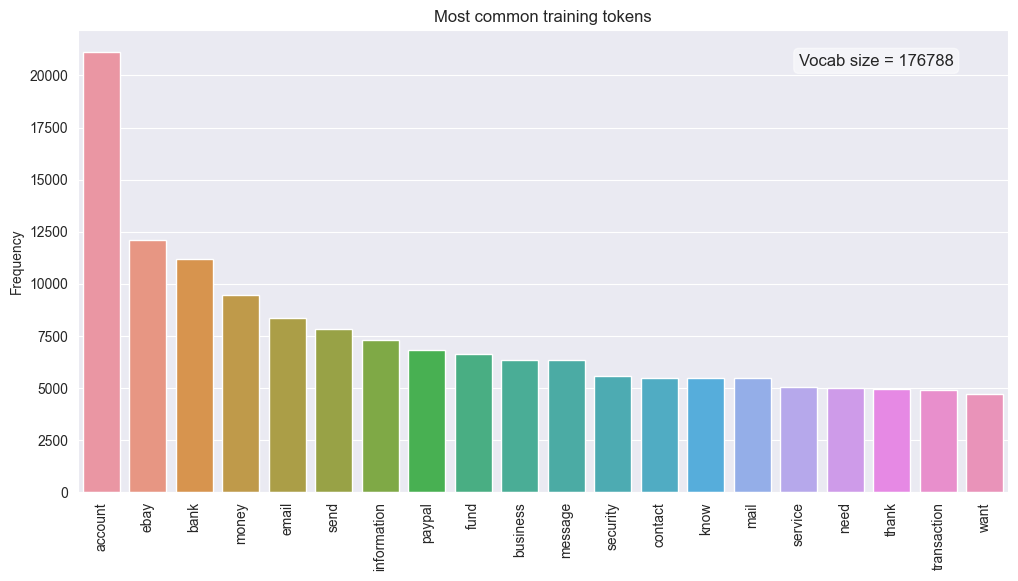

In [428]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=vocab_20.index, y=vocab_20.values, ax=ax)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.775, 0.95, f'Vocab size = {len(vocab)}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_title('Most common training tokens')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

In [429]:
trigrams = nltk.trigrams(all_words)
trigram_freqs_20 = pd.Series({
    '_'.join(k): v for k, v in sorted(nltk.FreqDist(trigrams).most_common(20), key=lambda item:item[1], reverse=True)
})

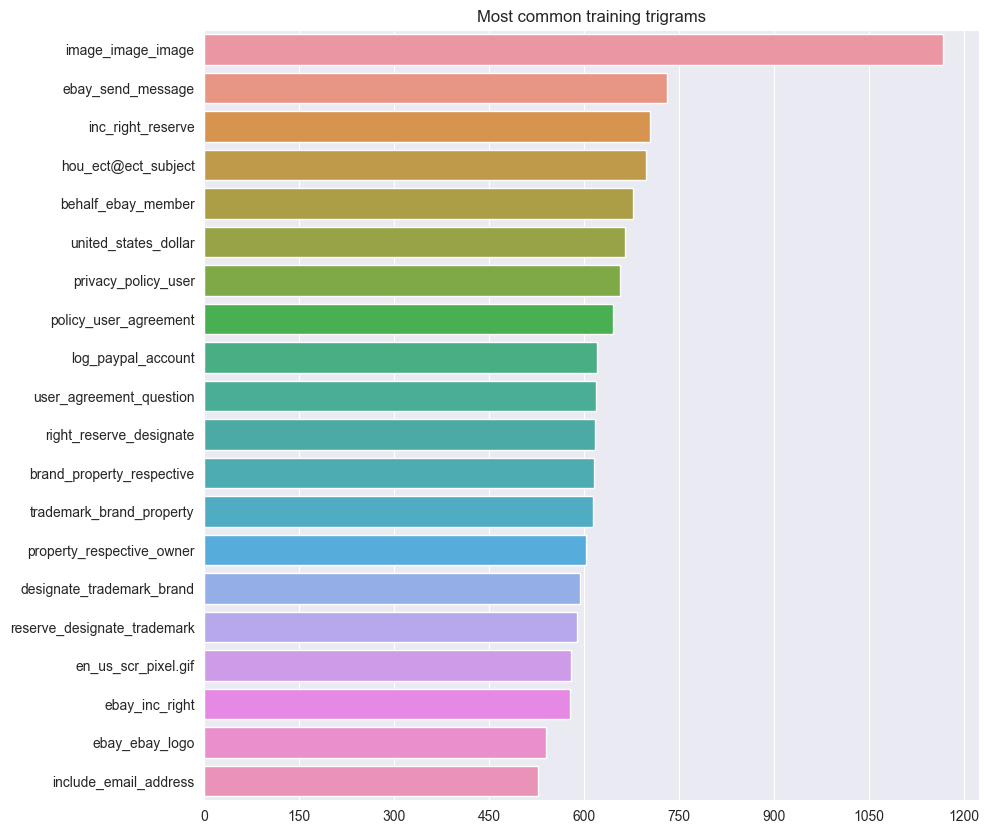

In [430]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=trigram_freqs_20.values, y=trigram_freqs_20.index, orient='h', ax=ax)
ax.set_title('Most common training trigrams')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# RNN Architecture

In [431]:
# Prepare training dataset
train_text, train_labels = (
    tf.data.Dataset.from_tensor_slices(x) for x in (X_train_clean, y_train)
)
train_ds = tf.data.Dataset.zip(datasets=(train_text, train_labels))

In [432]:
# Prepare validation dataset
val_ds = tf.data.Dataset.from_tensor_slices(tensors=(X_val_clean, y_val))

In [433]:
# Prepare testing dataset
test_ds = tf.data.Dataset.from_tensor_slices(tensors=(X_test_clean, y_test))

In [434]:
# Vocabulary size
VOCAB_SIZE = 50000 # 35000

# Max number of words for each sequence
MAX_LEN = 250

# Max embedding size
EMBED_DIM = 100

# Set batch size
BATCH_SIZE = 256

# Set n-grams
N_GRAMS = 3

# Set number of epochs for training
EPOCHS = 30

# Learning rate
LR = 1e-2

Build the model

In [435]:
class LSTMClassifier(Model):
    """
    LSTM Model for multi-category classification.

    Attributes
    ----------
    n_classes : int
        Number of output categories
    vocab_size : int
        Vocabulary size. By default 50 000.
    max_seq_len : int 
        Max number of words for each sequence. By default 250.
    embed_dim : int 
        Max embedding size. By default 100.
    n_grams : int 
        Number of tokens to embed into ngrams vector. By default 2.
    input_layer : tf.keras.layers.Input
        Input layer.
    vectorize_layer : tf.keras.layers.TextVectorization
        Layer to transfer text into vocabulary indices.
    embedding_layer : tf.keras.layers.Embedding
        Layer to map vocabulary indices into dense vectors.
    spatial_dropout : tf.keras.layers.SpatialDropout1D
        Layer to promote independence between feature maps.
    lstm_[n] : tf.keras.layers.LSTM
        Long Short-Term Memory layer(s) effectively memorize important embeddings.
    dense_[n] : tf.keras.layers.Dense
        Dense layer(s) increase the model's capacity to capture complex relationships.
    dropout_[n] : tf.keras.layers.Dropout
        Follows each Dense layer and regulates the network, keeping it far from any bias.
    classifier : tf.keras.layers.Dense
        Output layer.

    Methods
    -------
    handle_starttag(tag, attrs)
        Append new opening tags and attributes.

    handle_endtag(self, tag)
        Append new closing tags.
    
    contains_content_type(content_type)
        Return boolean flag indicating MIME content-type presence. 
    """ 
    
    def __init__(self, n_classes: int = 2, vocab_size: int = 50000, max_seq_len: int = 250, embed_dim: int = 100, n_grams: int = 2) -> None:
        """
        Constructs all the necessary attributes for the custom Model object.

        Parameters
        ----------
        n_classes : int, optional
            Number of output categories. Default is 2.
        vocab_size : int, optional
            Vocabulary size. Default is 50 000.
        max_seq_len : int, optional 
            Max number of words for each sequence. Default is 250.
        embed_dim : int, optional 
            Max embedding size. Default is 100.
        n_grams : int, optional 
            Number of tokens to embed into ngrams vector. Default is 2.
        """
        # Call parent constructor
        super(LSTMClassifier, self).__init__()
        
        # Assign variables to parameters
        self.n_classes = n_classes
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.n_grams = n_grams      
        
        # Define layers
        self.input_layer = Input(
            name='inputs', 
            shape=(1,), 
            dtype=tf.string
        )
        self.vectorize_layer = TextVectorization(
            max_tokens=self.vocab_size, 
            output_mode='int', 
            output_sequence_length=self.max_seq_len, 
            ngrams=self.n_grams,
            pad_to_max_tokens=True,
            name='vectorization_layer'
        )
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size + 1, 
            output_dim=self.embed_dim,
            name='embedding_layer'
        )
        self.spatial_dropout = SpatialDropout1D(rate=0.2)
        self.lstm_1 = LSTM(
            units=128, 
            dropout=0.2, 
            recurrent_dropout=0.2, 
            name='lstm_layer_01'
        )
        self.dense_1 = Dense(
            units=32, 
            activation='relu',
            name='dense_layer_01'
        )
        self.dropout_1 = Dropout(0.5)
        self.classifier = Dense(
            units=self.n_classes, 
            activation='softmax', 
            name='outputs'
        )
    
    def call(self, inputs) -> EagerTensor:
        """
        Build a new computational graph from the provided inputs and return the outputs as tensors.

        Parameters
        ----------
        inputs : {tf.Tensor, List[tf.Tensor], Tuple[tf.Tensor], Dict[str, tf.Tensor]}
            The input(s) of the model.
        
        Returns
        -------
        outputs : {tf.Tensor, List[tf.Tensor]}
            The output(s) of the model.

        """
        # TextVectorization layer is used to normalize, split, and map strings to integers (set `output_mode` to `int`), thus needs to be instantiated before calling the model.
        # This layer transforms input document into a tensor of shape (batch_size, max_len) containing vocab indices.
        # Explicitly set maximum sequence length, as the LSTM layers do not support ragged sequences.
        # These layers are non-trainable, thus their state (vocabulary) must be set before training.
        # The vocabulary for that layer must be either supplied on construction (precomputed constant) or learned via adapt().
        # Furthermore, TextVectorization layer uses an underlying StringLookup layer that also needs to be initialized beforehand. 
        # Otherwise, FailedPreconditionError: Table not initialized exception is raised.
        x = self.vectorize_layer(inputs)

        # Embedding layer is mapping those vocab indices into a space of dimensionality (embedding_dim,). 
        # Note that we're using max_features + 1 here, since there's an OOV token that is added to the vocabulary in vectorize_layer.
        x = self.embedding_layer(x)

        # SpatialDropout1D performs variational dropout in NLP models.
        # It promotes the independence between single-dimensional feature maps instead of individual elements.
        x = self.spatial_dropout(x)

        # LSTM effectively memorizes important multiple word-level embeddings referring to a particular category.
        # While using multiple LSTM layers, the preceeding LSTM layer needs to return sequences.
        # Then, these sequences are passed as input to the next LSTM layer.
        x = self.lstm_1(x)

        # Following Dense layers increase the model's capacity to capture complex relationships.
        # A dropout layer is used for regulating the network and keeping it as away as possible from any bias.
        x = self.dense_1(x)
        x = self.dropout_1(x)

        # The output Dense layer with a softmax activation function returns prediction probability for each category.
        return self.classifier(x)

    def build_graph(self) -> Functional:
        """
        Helper function to get and plot the model summary information conveniently.
        Graphs are used by tf.functions to represent the function's computations. Each graph contains:
            - Set of tf.Operation objects, which represent units of computation
            - Set of tf.Tensor objects, which represent the units of data that flow between operations.

        Returns
        -------
        graph : keras.engine.functional.Functional
            Model architecture.

        Usage
        ----- 
        View model summary
            LSTMClassifier().build_graph().summary()
        
        Visualize the model graph
            tf.keras.utils.plot_model(
                LSTMClassifier().build_graph(),
                show_shapes=True,
                show_dtype=True,
                show_layer_names=True,
                rankdir="TB",
            )
        """
        x = self.input_layer
        return Model(inputs=x, outputs=self.call(x))

    def compute_vocabulary(self, text_data, batch_size: int = None, steps: int = None) -> None:
        """
        Computes a vocabulary of string terms from tokens in a dataset.

        Parameters
        ----------
        text_data : {tf.data.Dataset, np.ndarray}	
            Textual data to compute the vocabulary on.
        batch_size : int, optional
            Number of samples per state update. Supported with numpy array inputs only. Default is 32.  
        steps : int, optional 
            Total number of steps (batches of samples). Supported with tensorflow Dataset inputs only. Default is None. 

        Usage
        -----
        It is necessary to supply vocabulary to the TextVectorization layer, whenever a model is instantiated (before fitting).
        Input dataset can be batched to set the number of samples per state update.
        """
        self.vectorize_layer.adapt(text_data, batch_size, steps)


In [436]:
lstm = LSTMClassifier(vocab_size=VOCAB_SIZE, n_grams=N_GRAMS)
lstm.compute_vocabulary(train_text.batch(BATCH_SIZE))

In [437]:
lstm.compile(
    # Because it is a binary-class classification problem, binary_crossentropy is used as the loss function.
    # loss='binary_crossentropy',
    # However, we want to get the category index of the most like matching category.
    # Since our labels are integers and are not one-hot encoded, the sparse categorical crossentropy is used.
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=LR),
    metrics=['accuracy']
)

In [438]:
lstm.build_graph().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 vectorization_layer (TextVe  (None, 250)              0         
 ctorization)                                                    
                                                                 
 embedding_layer (Embedding)  (None, 250, 100)         5000100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm_layer_01 (LSTM)        (None, 128)               117248    
                                                                 
 dense_layer_01 (Dense)      (None, 32)                4128  

In [439]:
checkpoints_path = os.path.join(LSTM_PATH, 'checkpoints', datetime.now().strftime(r"%Y%m%d%H%m"))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-4, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4, verbose=1),
    ModelCheckpoint(filepath=checkpoints_path, monitor='val_loss', save_best_only=True, verbose=1)
]

In [440]:
history = lstm.fit(
    train_ds.batch(BATCH_SIZE), 
    validation_data=val_ds.batch(BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=callbacks
).history

Epoch 1/30
65/65 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.7967
Epoch 1: val_loss improved from inf to 0.28072, saving model to ..\models\LSTM\checkpoints\202211132311
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202211132311\assets
65/65 [==============================] - 190s 3s/step - loss: 0.4788 - accuracy: 0.7967 - val_loss: 0.2807 - val_accuracy: 0.9178 - lr: 0.0100
Epoch 2/30
65/65 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9421
Epoch 2: val_loss did not improve from 0.28072
65/65 [==============================] - 181s 3s/step - loss: 0.1908 - accuracy: 0.9421 - val_loss: 0.3461 - val_accuracy: 0.9101 - lr: 0.0100
Epoch 3/30
65/65 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9744
Epoch 3: val_loss improved from 0.28072 to 0.08791, saving model to ..\models\LSTM\checkpoints\202211132311
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202211132311\assets
65/65 [==

In [441]:
lstm = tf.keras.models.load_model(checkpoints_path)

In [442]:
scores = lstm.evaluate(test_ds.batch(BATCH_SIZE), verbose=0)
print('Test set scores:\n - Loss: {:.4f}\n - Accuracy: {:.4f}'.format(*scores))

Test set scores:
 - Loss: 0.0654
 - Accuracy: 0.9879


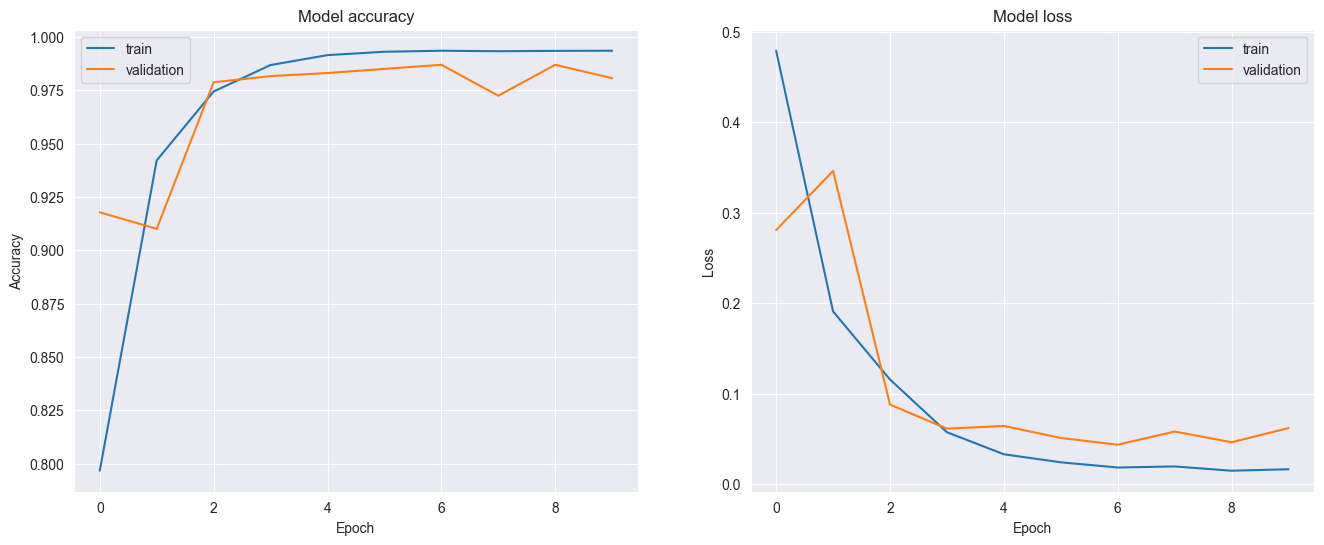

In [444]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history[metric], label='train')
    ax[i].plot(history[f'val_{metric}'], label='validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_ylabel(metric.title())
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

plt.show()

# Export model

In [445]:
if SAVE_MODEL:
    lstm.save(LSTM_PATH)
    print(f'[!] Model saved as {os.path.abspath(LSTM_PATH)}')